<a href="https://colab.research.google.com/github/gmortuza/image-processing/blob/master/hw/hw1/hw_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center; font-weight:bold;font-size:30px;">EE5557</p>
<p style="text-align:center; font-weight:bold;font-size:30px;">Homework</p>
<p style="text-align:center; font-weight:bold;font-size:30px;">Golam Mortuza</p>

# Import library

In [ ]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import matplotlib
from PIL import Image
matplotlib.rcParams.update({'font.size': 22})


In [ ]:
fig_a = "22_a.tif"
fig_c = "22_c.tif"

# Part 1 – Spatial Subsampling

In [ ]:
def read_image(path):
    return np.asarray(image.imread(path))

def downsample(path, method='impulse', factor=2):
    def impulse(img, factor):
        return img[0: -1: factor, 0: -1: factor]
    
    def maxpool(img, factor):
        height, width = img.shape
        _height, _width = height//factor, width//factor
        return img[:_height*factor, :_width*factor].reshape(_height, factor, _width, factor).max(axis=(1, 3))
    
    def average(img, factor):
        height, width = img.shape
        _height, _width = height//factor, width//factor
        return img[:_height*factor, :_width*factor].reshape(_height, factor, _width, factor).mean(axis=(1, 3))
        
    
    img = image.imread(path)
    if method == 'impulse':
        return impulse(img, factor)
    elif method == 'maxpool':
        return maxpool(img, factor)
    elif method == 'average':
        return average(img, factor)
    else:
        raise Exception("Method not supported")
        

def upsample_nearest(img, factor=2):
    """
    Nearest neighbour only
    """
    return img.repeat(factor, axis=0).repeat(factor, axis=1)

def show_figs(path):
    figs, axes = plt.subplots(6, 3, figsize=(30, 30))
    types = ['impulse', 'maxpool', 'average']
    factors = [2, 4, 8]
    for i, _type in enumerate(types):
        for j, factor in enumerate(factors):
            downsampled = downsample(path, _type, factor)
            axes[i*2][j].imshow(downsampled, cmap="gray")
            axes[(i*2) + 1][j].imshow(upsample_nearest(downsampled, factor), cmap="gray")
            axes[i*2][0].set_ylabel(_type)
            axes[(i*2) + 1][0].set_ylabel("Upsampled")
            axes[0][j].set_xlabel(f"Factor: {factor}")
            axes[0][j].xaxis.set_label_position('top')
    figs.suptitle("Image subsampling and upsampling with factor 2, 4, 8")
    figs.text(0.5, 0.08, 'Factors', ha='center', va='center')
    figs.text(0.1, 0.5, 'Subsampling method', ha='center', va='center', rotation='vertical')

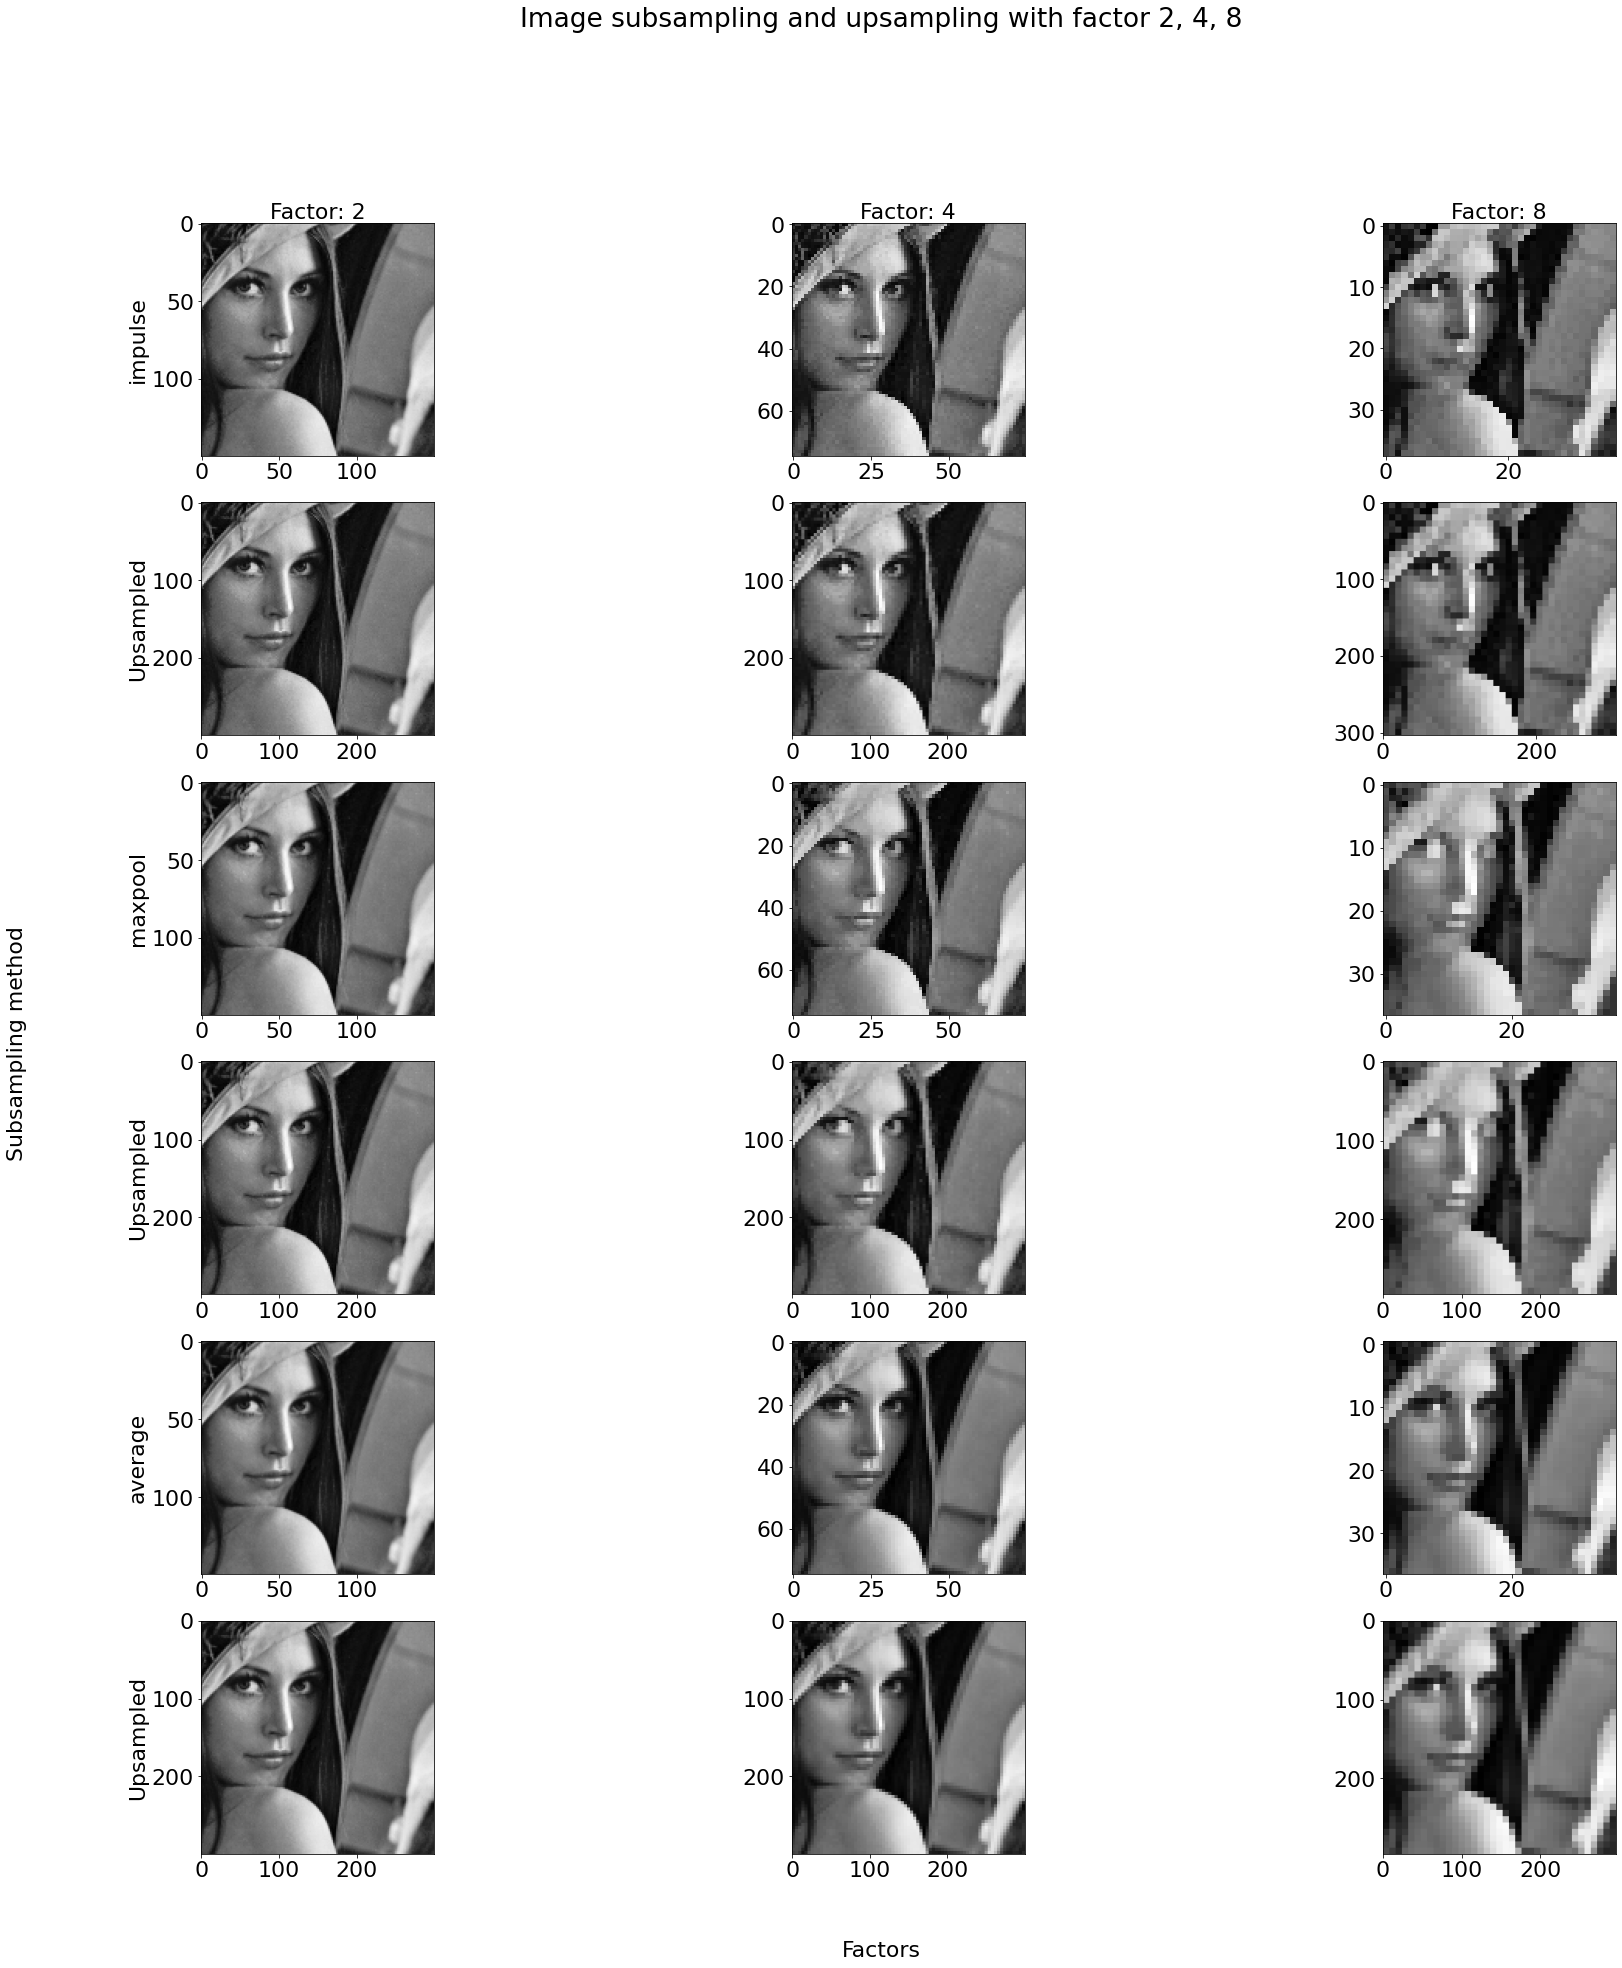

In [ ]:
show_figs(fig_a)

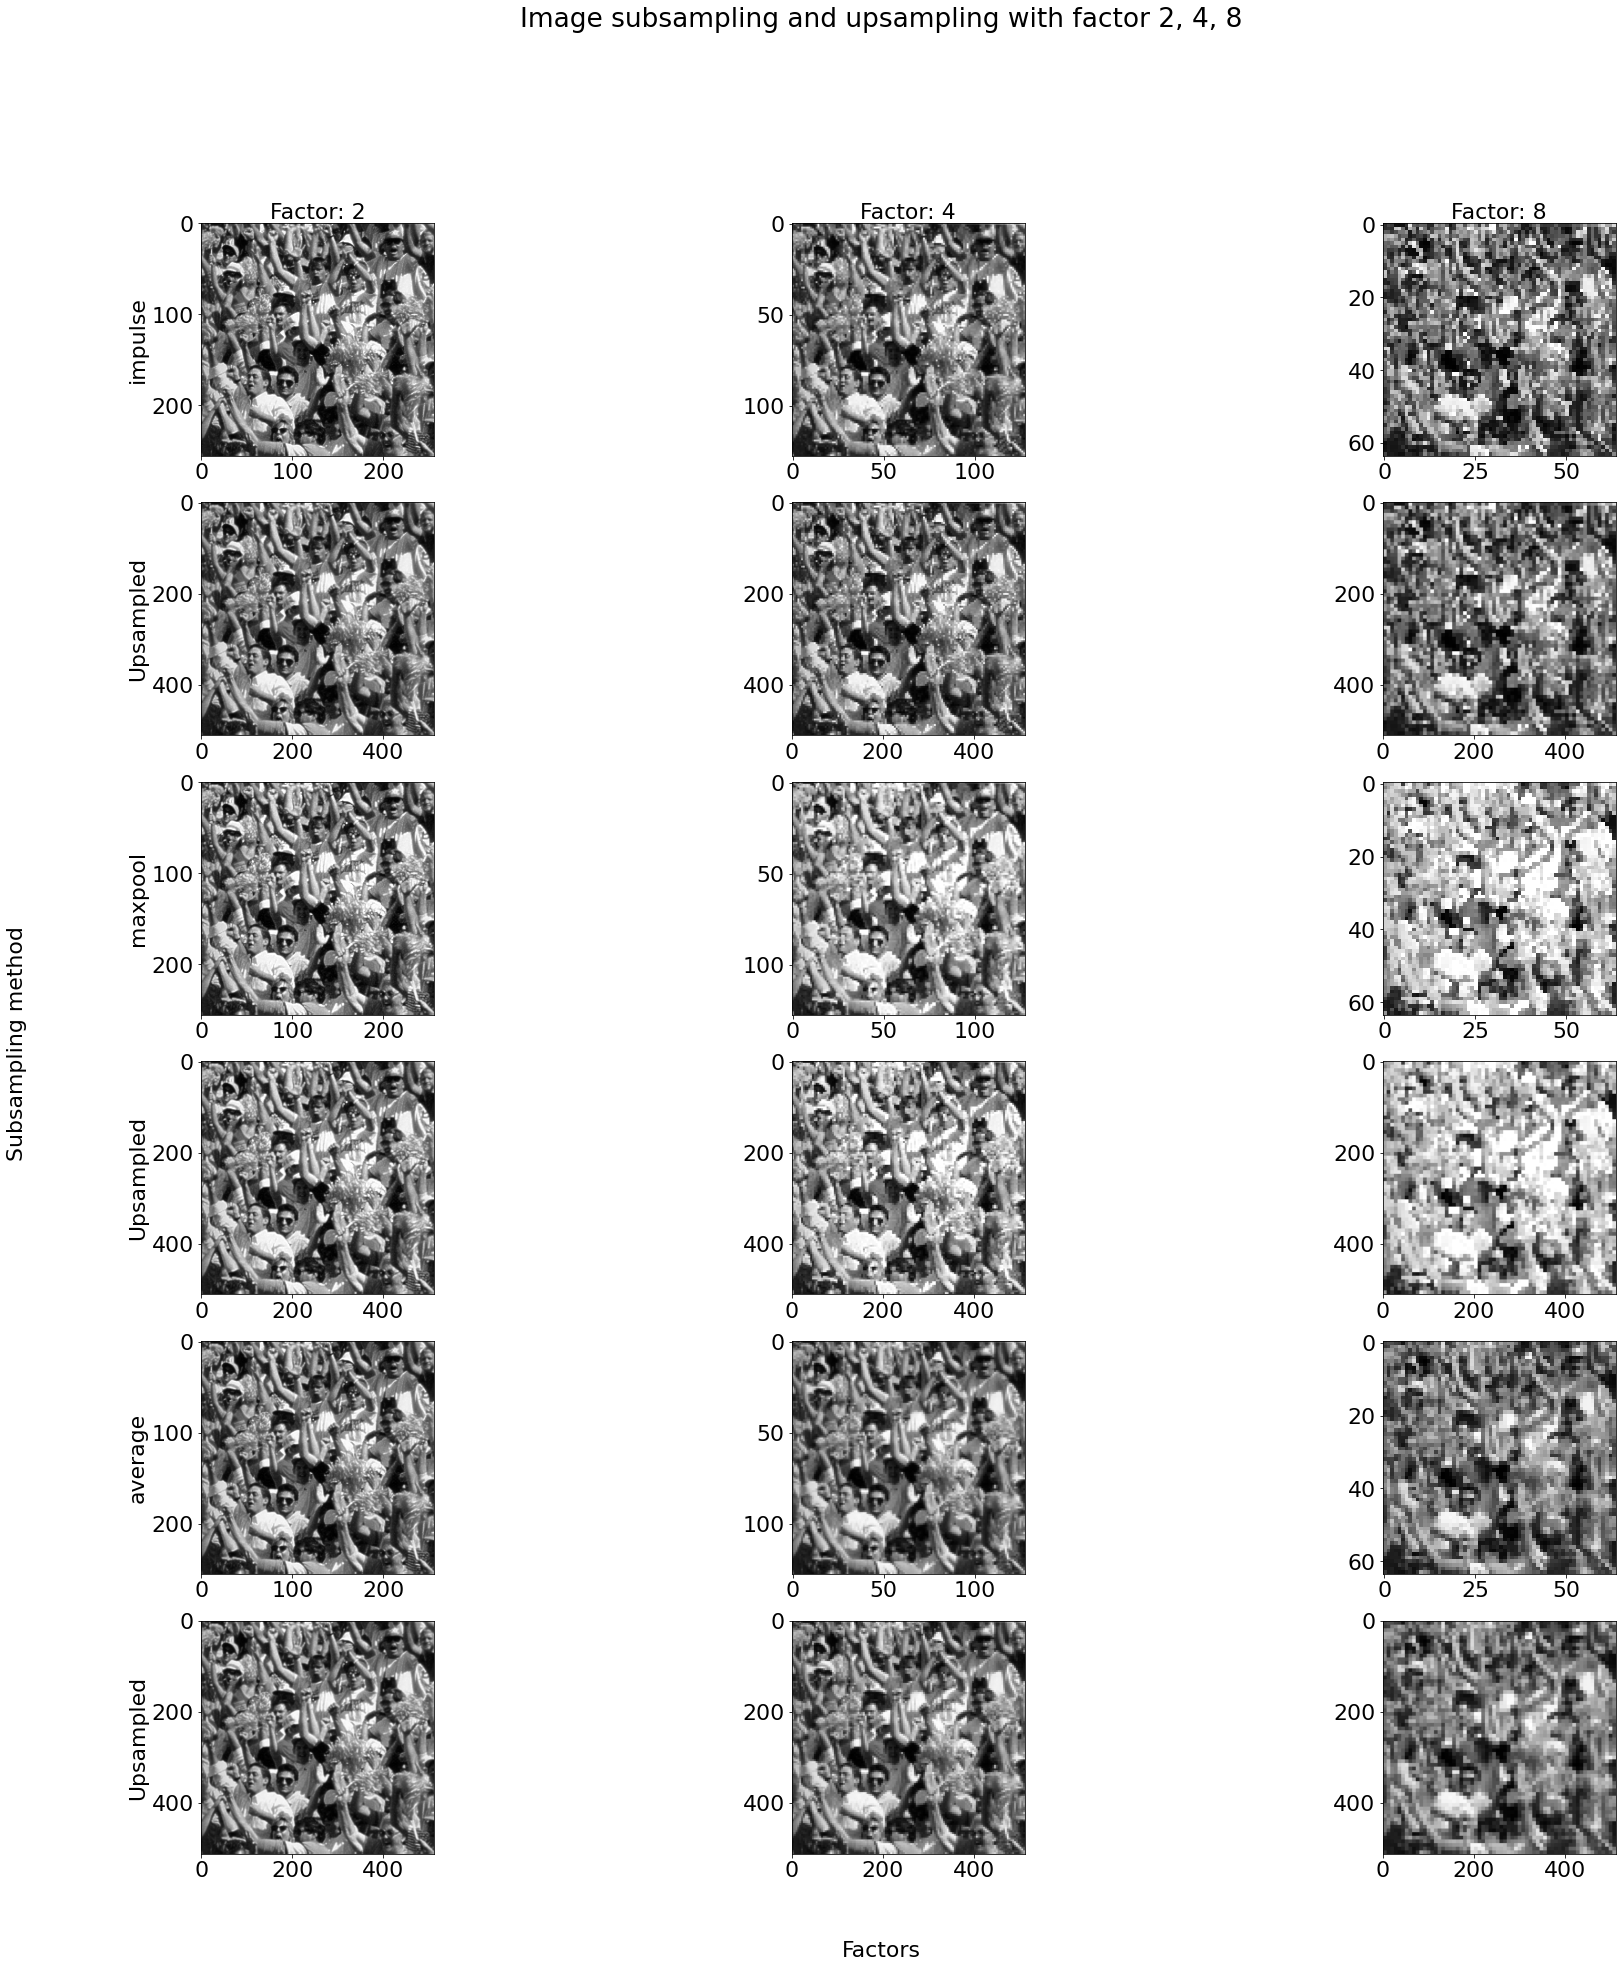

In [ ]:
show_figs(fig_c)

## Discussion

Image that have factor size 2 and 4 does't show much of difference compared to the original images. However factor size 8 shows a huge difference compared to the original image. We are loosing almost 88% information(bits) during this downsampling process(factor 8). Nearest neighbour method is tested during the upsampling method. It did a pretty good job reconstructing the image into the original shape.
Among all the downsampling method(impuslse, maxpooling, average), maxpooling seems to have a worst result. The reason might be, only one bit is from the subsection. All the other bits are just ignored. But in the average downsampling we are considering all the bits. So we are not just wasting those bits. Instead all the bits contirubte to reconstruct the original image.

# Part II – Intensity quantization

In [ ]:
def quantize(path, intensity=8):
    if isinstance(path, str):
        img = read_image(path)
    else:
        img = path
    mask = np.linspace(0, 256, intensity)
    mask = np.repeat(mask, 2)[1:-1].reshape(-1, 2)
    mask = np.mean(mask, axis=1)
    mask = [0] + list(mask) + [255]
    new_img = np.zeros(img.shape)
    for i in range(0, len(mask)):
        will_change = np.logical_and(img>=mask[i-1], img<mask[i])
        new_img[will_change] = mask[i]
    return new_img

def show_quantize_figs(path):
    figs, axes = plt.subplots(2, 2, figsize=(30, 30))
    intensities = [[256, 64], [16, 4]]
    row, col = 0, 0
    for _ in range(4):
        quantized = quantize(path, intensities[row][col])
        axes[row][col].imshow(quantized, cmap="gray")
        axes[row][col].set_title(f"{intensities[row][col]} gray values")
        col += 1
        if col >= 2:
            row += 1
            col = 0

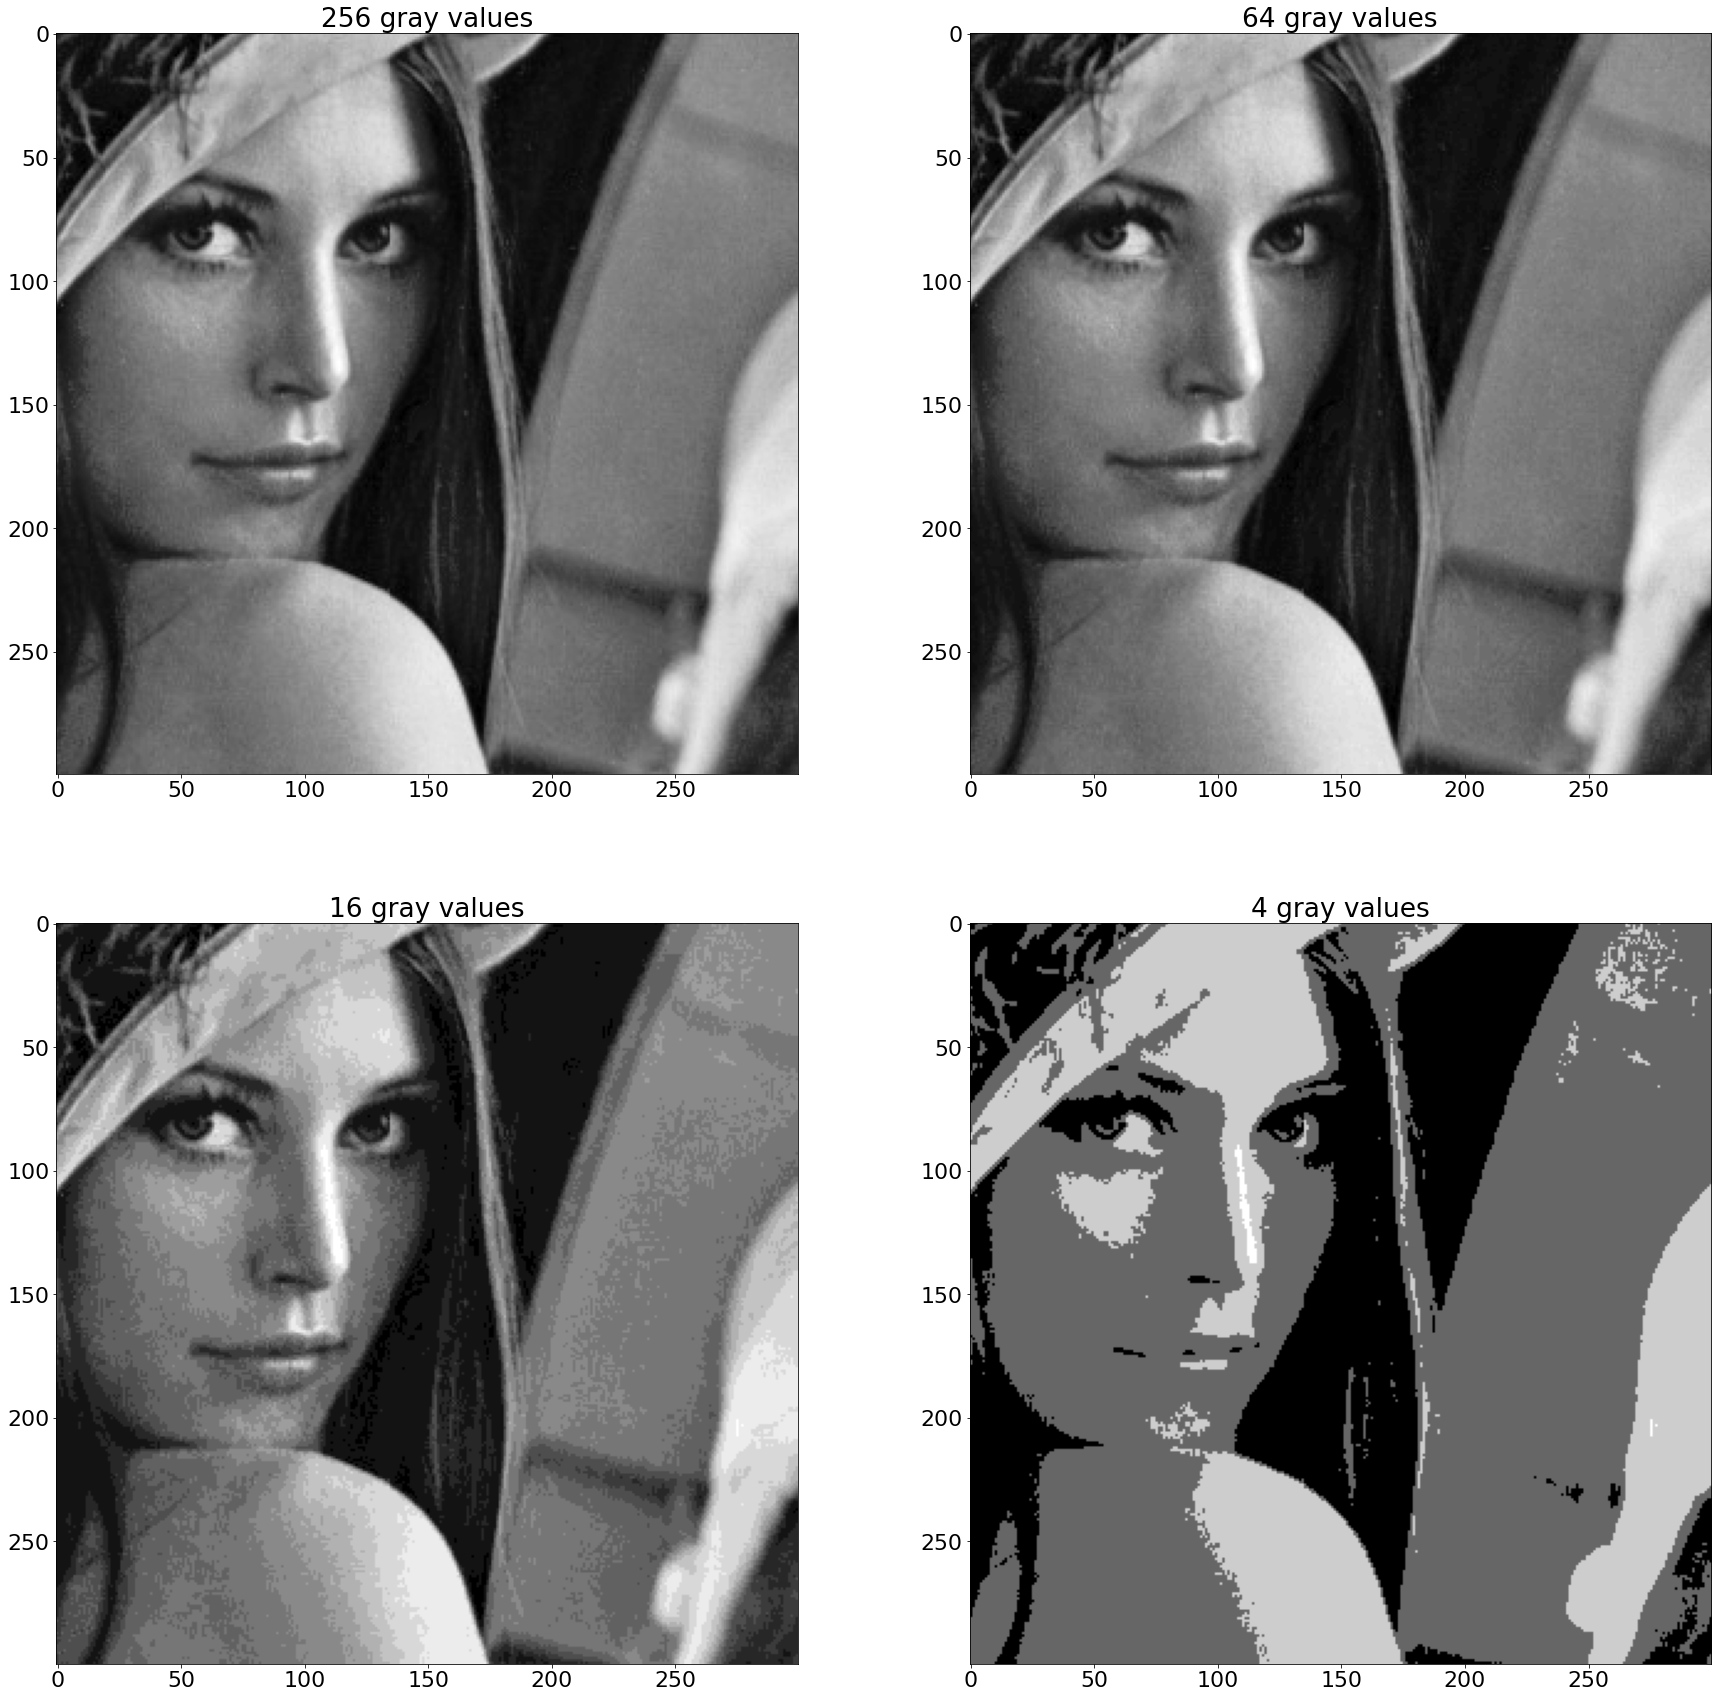

In [ ]:
show_quantize_figs(fig_a)

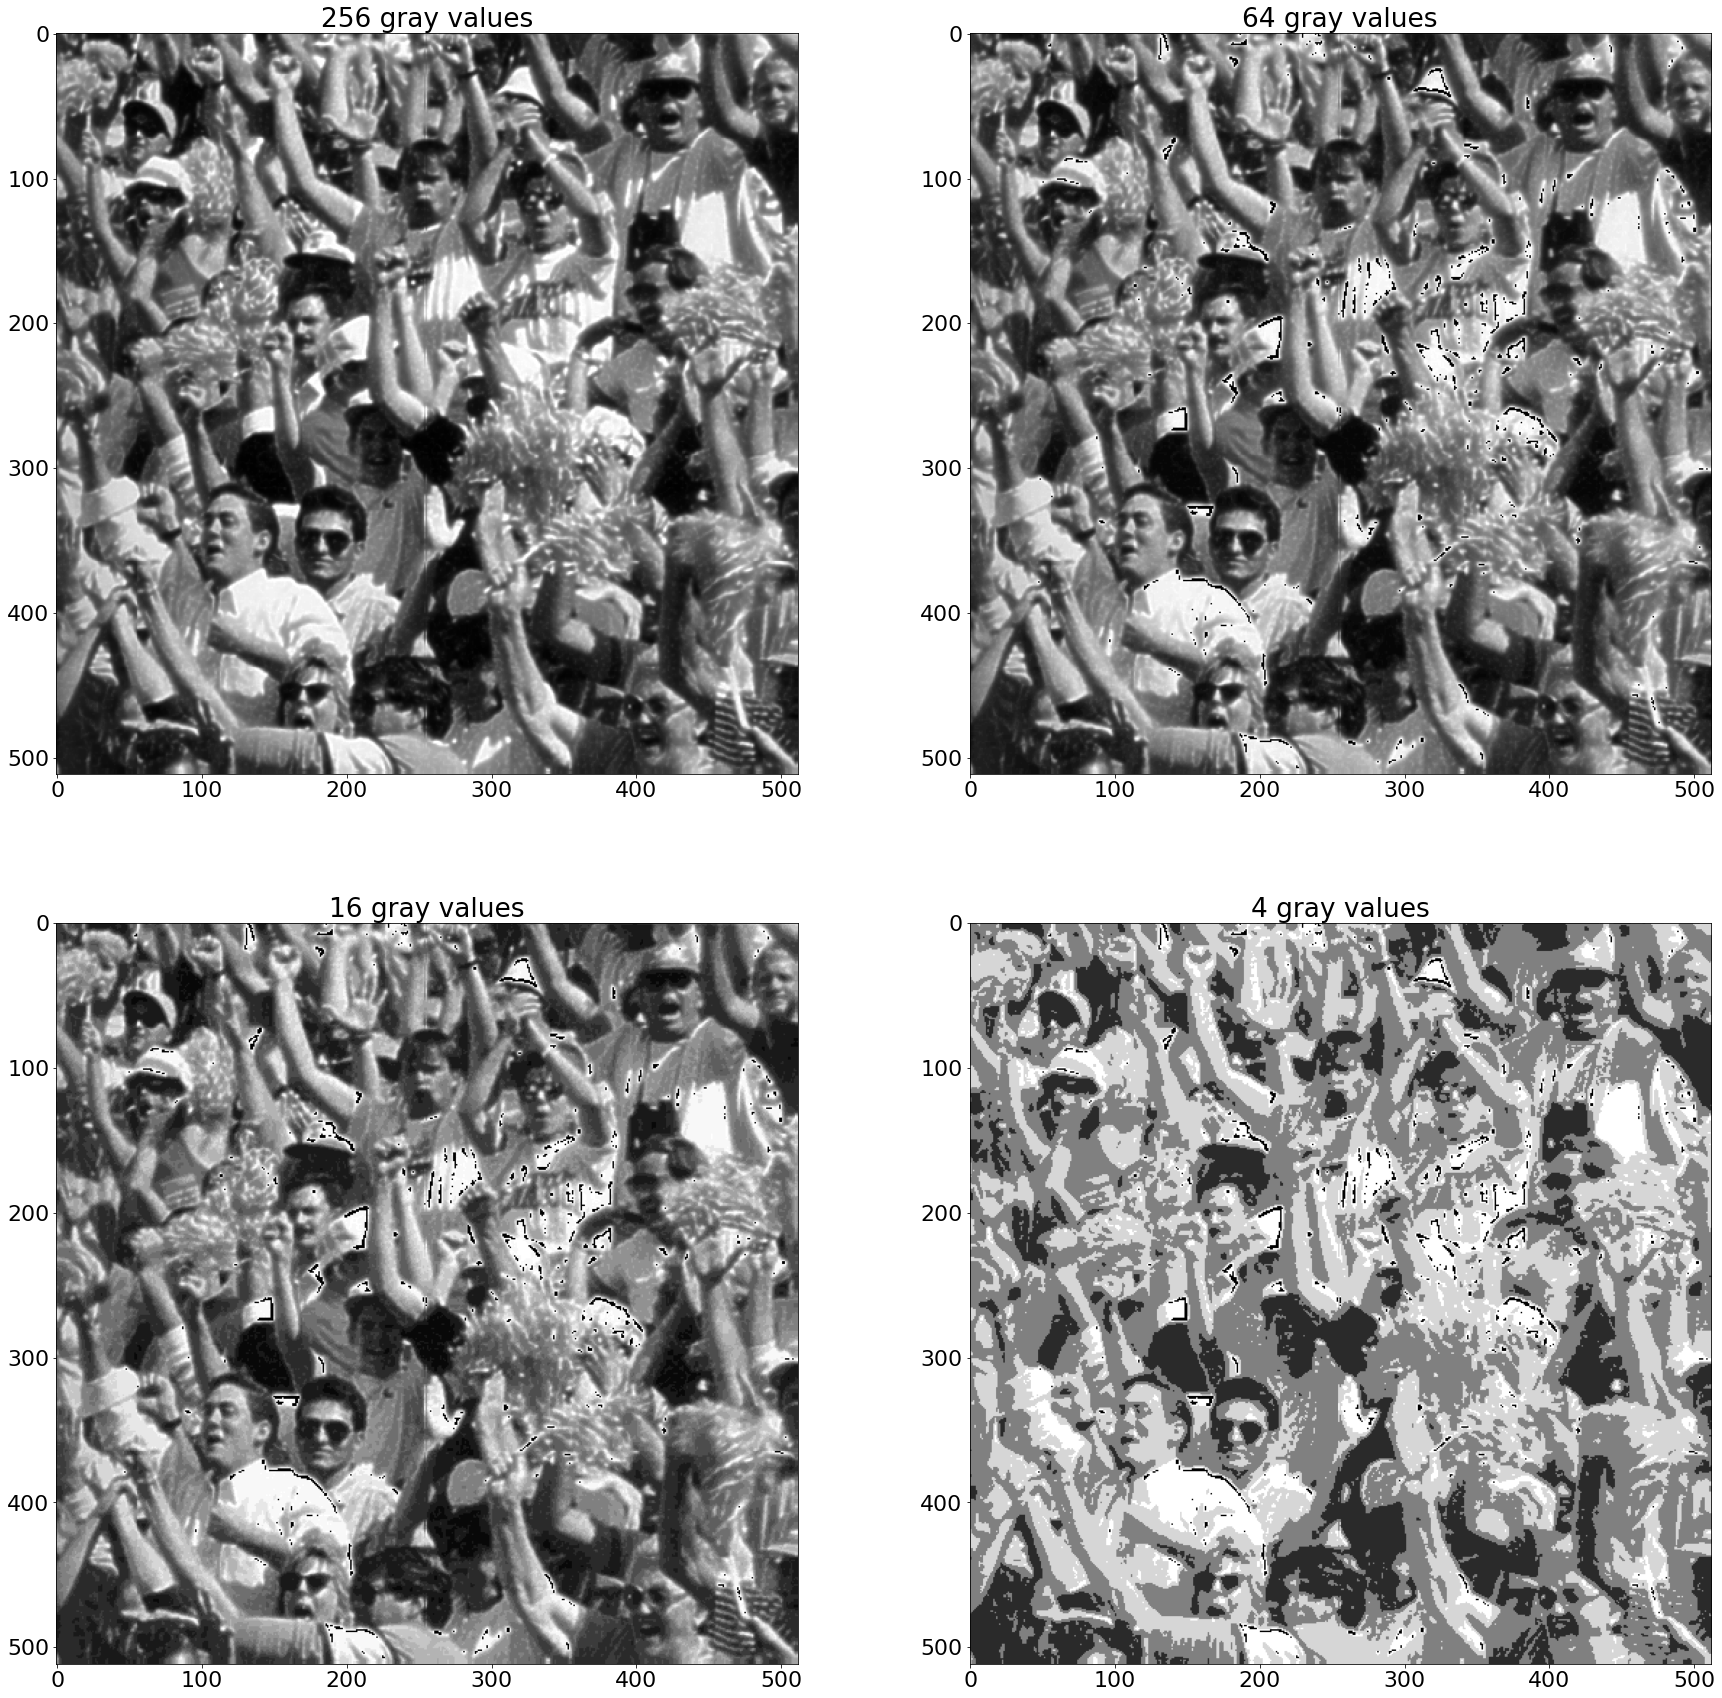

In [ ]:
show_quantize_figs(fig_c)

## Discussion


The crowd image and the face image shows different result here. In case of face image there is not a lot difference between 64 grayscale value and the original value. However, in the gray picture there is a lot of difference between original picture and 64 grayscale value. One reason might be there is not a lot of color varity in the face image but the in the crowd picture's pixel value varies a lot. Different people have different color, different shape, appearence. Probably that's why this picture is more sensitive than the other face picture. For the simplicity of the face picture it doesn't require a lot of gray level.

To quantize different grayscale level, I first take a quidistance range between 0 and 255. If any of the pixel value fall in any particular range value then I just replace that pixel value with the average of the range value

# Part III – Isopreference curves

In [ ]:
def plot_isopreference(path, size=(32, 256), intensity=(2,12), img_size=300, num_plot=10):
    figs, axes = plt.subplots(num_plot, num_plot, figsize=(30, 30), sharex=False, sharey=False)
    min_factor, max_factor = img_size/size[0], img_size/size[1]
    sizes = np.linspace(min_factor, max_factor, num_plot).astype(int)
    intensities = np.linspace(intensity[0], intensity[1], num_plot).astype(int)
    for k, i in enumerate(reversed(list(intensities))):
        for l, f in enumerate(sizes):
            downsampled = downsample(path, method='impulse', factor=f)
            quantized = quantize(downsampled, intensity=i)
            #resized = np.array(Image.fromarray(quantized).resize((50, 50), Image.NEAREST))
            axes[k][l].imshow(quantized, cmap="gray", interpolation='nearest')
            axes[k][l].set_aspect('equal')
            axes[k][l].set_yticklabels([])
            axes[k][l].set_xticklabels([])
            axes[-1][l].set_xlabel(f"size: {img_size//f}")
            axes[0][l].xaxis.set_label_position('bottom')
            axes[k][0].set_ylabel(f"intensity = {i}")
    plt.subplots_adjust(wspace=.05, hspace=.05)
    plt.show()
    
def save_picture(path, name, intensity, size, img_size):
    factor = img_size//size
    downsampled = downsample(path, method='impulse', factor=factor)
    quantized = quantize(downsampled, intensity=intensity)
    matplotlib.rcParams.update({'font.size': 11})
    plt.figure(figsize=(1, 1), dpi=300)
    plt.imshow(quantized, cmap="gray")
    plt.axis("off")
    plt.savefig(name)

## Discussion


Because of the complexity of the image it was pretty hard to find the optimum curve for the crowd picture. However isopreference curve for the face image was pretty straight forward and easy to find. The crowd picture perform worse on the lowest level of the intensity(grayscale level). The size in this case have hardly have any effect. Too much thing is going on a single picture. So we need more gray scale level to clearly show up those picture. That might be the reason. 
On the other hand the face picture have effect on both image resulation and intensity. I believe the intensity and the resolution plays an equal role in this case. This is the reason the isopreference curve is more curvy(face_curve_1.png) than the isopreference curve in crowd picture. However, the effect of the resolution and intensity seems to gone after those hit a certain threshold. 

# Literature (required for ECE557 only)

The author have demonastrated a method to compare the quality of the images. For that purpose they use a comparision unit called noticeable difference(JND). Overall method is consist of three parts. (i) a set of ruler image (ii) a software - display ruler and test picture (iii) a veiwing environment - a monitor. The ruler image is kind of the scale for measuring quality(like training image in ML). The software shows the ruler image and the test image side by side. A user changes different settings i.e. sharpness, blurriness etc. using a scale. The software measure how the test image is aligning with the scale image. It also record how much time did user took to make ruler image and the test image same. However it is not stated how exactly did they calculated JND unit from these feature.

The main problem of "Ruler enables calibrated image quality measurement" is it requires a human intervention to test the image. Different person will have different comments on a same image. So it can not have the same measurement all the time. The quality measure of the image will always depend who is measuring it. During creating the isopreference curve we also had the similar problem. Human is measuing the quality. If some on draw a isopreference curve one way it is not unlikely that other person will disagree with that. So I think the above approch didn't sovle the main problem instead it uses the same approch but in a different way.